# Router V0.0
Energy efficienty based truck router!

In [534]:
import osmnx as ox
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import randrange
import copy

In [123]:
from IPython.core.display import display, HTML, Markdown

## Utils
Classes for interacting with the road network

In [1648]:
class RoadNetwork:
    def __init__(self):
        self.graph = None
        
        self.nodes = None
        self.edges = None
    
    # ===================== LOADING AND PREPROCESSING
    # Load a graph from a file
    def load_from_file(self, filename):
        self.graph = ox.graph_from_xml(filename, bidirectional = False, simplify = True, retain_all=False)
    
    # Remove non highway edges
    def remove_non_highway(self):
        edges_to_remove = []
        G = self.graph

        # Find edges that are not highways (roads)
        for n in G.edges:
            # print(n)
            data = G.edges[n]
            if('highway' not in data):
                # print("Not a highway")
                edges_to_remove.append(n)
                pass
            elif('area' in data):
                edges_to_remove.append(n)

        # Remove them
        for edge_id in edges_to_remove:
            G.remove_edge(edge_id[0], edge_id[1])

        # Trim nodes with no connection
        remove = [node for node,degree in dict(G.degree()).items() if degree == 0]
        G.remove_nodes_from(remove)
    
    # Converts graph into geo-dataframe
    def graph_to_gdfs(self):
        self.nodes, self.edges = ox.graph_to_gdfs(self.graph)
    
    # Pre-processes the network to make it easier to navigate on
    def preprocess(self):
        self.remove_non_highway()
        self.graph_to_gdfs()
        
    # ===================== GRAPH OPERATIONS
    # TODO: OPTIMIZE THESE!!!
    
    # TODO: Make good subgraph interface, restrict search space
    
    # Returns list of node ids contained within graph
    def get_node_ids(self):
        return self.nodes.index
    
    # Gets node data from openstreetmap id
    def get_node(self, osmid):
        node = self.nodes[self.nodes.index == osmid].iloc[0]
        return node
    
    def get_edge_ids(self):
        return self.edges.index
    
    def get_edge(self, edge_id):
        return network.edges.loc[edge_id]
    
    def get_edge_df(self, edge_id):
        return network.edges.loc[edge_id[0], edge_id[1], :]
    
    def get_connected_edges_from_node(self, node):
        return network.edges.loc[node.name, :, :]
    
    # ===================== PLOTTING
    # Basic node edge plot
    def plot_basic(self, figsize = (8, 8)):
        fig, ax = plt.subplots(figsize = figsize)
        
        # Plot nodes and edges
        self.nodes.plot(ax = ax, color = "black", alpha = 0.3, markersize = 1)
        self.edges.plot(ax = ax, color = "black", alpha = 0.1)
        
        ax.axis('off')
        
        # return the axis incase we want to plot more ontop
        return fig, ax
    
    # Plots a point
    def plot_point(self, ax):
        pass
    
    # Plots a node
    def plot_node(self, ax, node, color = "orange"):
        x, y = node['x'], node['y']
        
        ax.scatter([x], [y], color = color)
        
    # Plots a node from its id
    def plot_node_from_id(self, ax, osmid, color = "orange"):
        node =  self.get_node(osmid)
        self.plot_node(ax, node, color)
    
    def _repr_html_(self):
        self.plot_basic((5,5))
        return ""

## Network loading and inspection

plotting..


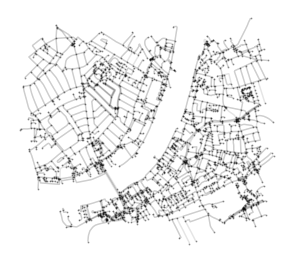

In [1659]:
network = RoadNetwork()
network.load_from_file('wands3.osm')
network.preprocess()
network.preprocess()
network.preprocess()
print("plotting..")
network

### Plotting a single, random node

#### [Node ID: 3120280977](https://www.openstreetmap.org/node/3120280977)

y                              51.471739
x                              -0.177218
highway                              NaN
ref                                  NaN
geometry    POINT (-0.1772179 51.471739)
Name: 3120280977, dtype: object


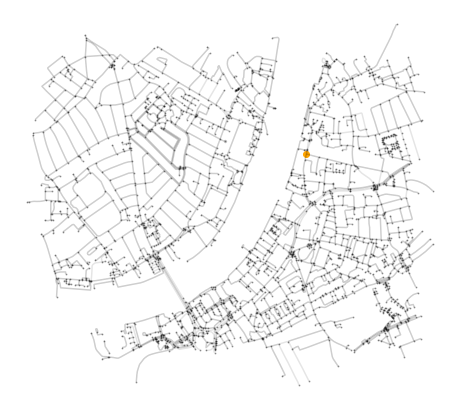

In [1665]:
# Get all ids and pick a random one
node_ids = network.get_node_ids()
test_id = node_ids[randrange(0, len(node_ids))]
test_id = 3120280977

# Display id with a link to the osm page
display(Markdown("#### " + "[Node ID: %s](https://www.openstreetmap.org/node/%s)" % (test_id, test_id)))

# Get the node data
node = network.get_node(test_id)
print(node)

# Plot the node
fig, ax = network.plot_basic()
network.plot_node(ax, node)

### Plotting a single, random edge

#### [Edge ID: (27026836, 27026809, 0)](https://www.openstreetmap.org/way/4415646)

#### [Node 1 ID: 27026836](https://www.openstreetmap.org/node/27026836)

#### [Node 2 ID: 27026809](https://www.openstreetmap.org/node/27026809)

osmid                                                 4415646
ref                                                       NaN
name                                            Maysoule Road
highway                                           residential
maxspeed                                               20 mph
oneway                                                  False
length                                                 29.098
geometry    LINESTRING (-0.1788996 51.4635979, -0.17926 51...
lanes                                                     NaN
junction                                                  NaN
bridge                                                    NaN
access                                                    NaN
tunnel                                                    NaN
service                                                   NaN
width                                                     NaN
Name: (27026836, 27026809, 0), dtype: object


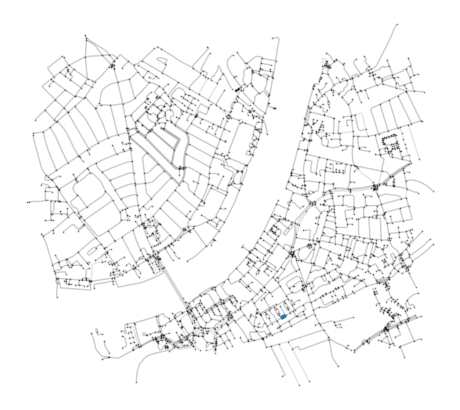

In [1662]:
# Get all edge ids and pick a random one
edge_ids = network.get_edge_ids()
test_id = edge_ids[randrange(0, len(edge_ids))]

edge = network.get_edge(test_id)

display(Markdown("#### " + "[Edge ID: %s](https://www.openstreetmap.org/way/%s)" % (test_id, edge['osmid'])))

display(Markdown("#### " + "[Node 1 ID: %s](https://www.openstreetmap.org/node/%s)" % (test_id[0], test_id[0])))
display(Markdown("#### " + "[Node 2 ID: %s](https://www.openstreetmap.org/node/%s)" % (test_id[1], test_id[1])))


print(edge)

edge_df = network.get_edge_df(test_id)
# Plot the edge
fig, ax = network.plot_basic()
edge_df.plot(ax = ax, linewidth = 4)
display()

### Getting connected ways

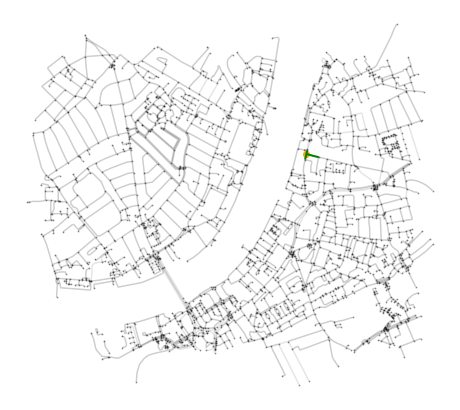

In [1666]:
connected_edges = network.edges.loc[node.name, :, :]
connected_edges

# Plot network
fig, ax = network.plot_basic()

# Plot node
network.plot_node(ax, node)

# Plot connected edges
connected_edges.plot(ax = ax, linewidth = 2, color = "green")
display()

## Dijkstra’s algo

In [1716]:
node_ids = copy.copy(network.get_node_ids())

#source_node_id = node_ids[1]
source_node_id = 27089788
goal_node_id = node_ids[185]
# goal_node_id = 3380860046
print(source_node_id)

distances = pd.DataFrame({"dist": pd.Series(dtype='float'), "prev": pd.Series(dtype='int')}, index=node_ids)
#distances.set_index(node_ids)
Q = node_ids

distances['dist'][source_node_id] = 0.0
#distances['prev'][source_node_id] = source_node_id

print(distances['prev'][source_node_id].astype("int64"))

edge_list = []

filenames = []

27089788
-9223372036854775808


In [1714]:
def iterate_dijkstras():
    global Q
    
    # For the nodes remaining in Q, find the one with the shortest distance
    u = distances[distances.index.isin(Q)]['dist'].idxmin()

    # Drop the node from the reminaing list to search
    Q = Q.drop(u)

    # Add new things
    edge_list.append((distances['prev'][u].astype("int64"), u, 0))
    
    try:
        # Find connected edges
        connected_edges = network.edges.loc[u, :, :].index

        # Loop through edges
        for edge_id in connected_edges:
            # Pick second node
            v = edge_id[1]
            length = network.edges['length'][edge_id]
            # print(length)

            # Calculate distance from starting node to current node
            alt = distances['dist'][u] + length

            # print(u, v)

            # If the distance is lower than the current distance,
            # set it as the current shortest distance for the node and
            # set previous node
            if alt < distances['dist'][v] or np.isnan(distances['dist'][v]):
                distances['dist'][v] = alt
                distances['prev'][v] = u
    except KeyError:
        print("lol")
        
    if(len(Q) % 100 == 0):
        print("100th iter")
        
        fig, ax = network.plot_basic((10, 10))
        
        filename = f'{len(Q)}.png'
        plt.savefig(filename)
        plt.close()
        
    # print(len(Q))

In [1701]:
def dijkstras_reverse():
    node_ids = []
    edge_ids = []
    u = goal_node_id
    prev_u = 0
    
    if( (not np.isnan(distances['prev'][u])) or u != source_node_id):
        while not np.isnan(u):
            node_ids.insert(0, u)
            
            prev_u = u
            u = distances['prev'][u]
            edge_ids.append((u, prev_u, 0))
            
    # print(edge_ids[:-1])
    edges = network.edges[network.edges.index.isin(edge_ids[:-1])]
    print(len(edge_ids[:-1]))
    print(len(edges))
        
    return node_ids, edges

In [ ]:
while goal_node_id in Q:
    iterate_dijkstras()
    
node_ids, edges = dijkstras_reverse()
print("done!")

100th iter
100th iter
100th iter
100th iter
100th iter
100th iter
100th iter
100th iter
100th iter
100th iter


In [1676]:
edges

,,,osmid,ref,name,highway,maxspeed,oneway,length,geometry,lanes,junction,bridge,access,tunnel,service,width
u,v,key,,,,,,,,,,,,,,,
21393725,27027262,0,772511333,NaN,NaN,cycleway,NaN,False,90.906,"LINESTRING (-0.18066 51.46787, -0.18008 51.46860)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
27027220,27027227,0,"[455386520, 455386519]",NaN,Clove Hitch Quay,cycleway,NaN,False,86.982,"LINESTRING (-0.18289 51.46597, -0.18242 51.466...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
27027227,7872780158,0,455386520,NaN,Clove Hitch Quay,cycleway,NaN,False,30.374,"LINESTRING (-0.18207 51.46656, -0.18179 51.46677)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
27027228,7869652942,0,455386520,NaN,Clove Hitch Quay,cycleway,NaN,False,16.593,"LINESTRING (-0.18175 51.46680, -0.18160 51.46691)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
27027247,27027260,0,455386520,NaN,Clove Hitch Quay,cycleway,NaN,False,33.806,"LINESTRING (-0.18145 51.46701, -0.18123 51.46728)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869712847,7869712866,0,"[45832209, 70711612]",NaN,NaN,cycleway,NaN,False,57.743,"LINESTRING (-0.18554 51.46467, -0.18490 51.464...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
7869712866,583344093,0,70711612,NaN,NaN,cycleway,NaN,False,18.839,"LINESTRING (-0.18483 51.46494, -0.18459 51.46503)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
7869712887,2563446195,0,455386519,NaN,NaN,cycleway,NaN,False,28.364,"LINESTRING (-0.18391 51.46531, -0.18356 51.46544)",NaN,NaN,NaN,NaN,NaN,NaN,NaN


346


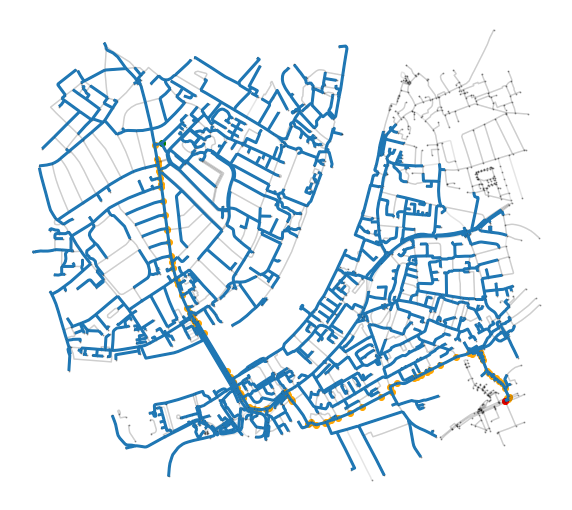

In [1713]:
# Plot network
fig, ax = network.plot_basic((10, 10))

edges = network.edges[network.edges.index.isin(edge_list)]
edges.plot(ax = ax, color = "black")


# Plot node
#network.plot_node_from_id(ax, u)
for node_id in node_ids:
    network.plot_node_from_id(ax, node_id)
    
network.plot_node_from_id(ax, source_node_id, "green")
network.plot_node_from_id(ax, goal_node_id, "red")

edges.plot(ax = ax, linewidth = 3)



print(len(Q))
# print(edge_list)

In [1234]:
network.edges[network.edges.index.isin([(8333764709, 4210749313, 0)])]

,,,osmid,lanes,ref,name,highway,maxspeed,oneway,length,geometry,access,service
u,v,key,,,,,,,,,,,
8333764709,4210749313,0,616345392,2,A217,Wandsworth Bridge Road,primary,20 mph,False,75.372,"LINESTRING (-0.19277 51.47602, -0.19249 51.47536)",NaN,NaN


In [915]:
network.edges.index

#edge_list

MultiIndex([(8333764709, 4210749313, 0),
            (8461004978,   27089772, 0),
            (8461004978, 8464405980, 0),
            (8461004978,   27089770, 0),
            (2204803282, 3965400001, 0),
            (2204803282, 3702436342, 0),
            (2204803282, 3702436349, 0),
            (1138944229, 1138944290, 0),
            (1138944238, 3450884703, 0),
            (1138944238, 3451067745, 0),
            ...
            (  14662752, 8464449407, 0),
            (  14662752,   14662754, 0),
            (  14662752,   14662751, 0),
            (7624016573, 7624016570, 0),
            (7624016574, 7624016570, 0),
            (7624016574, 7624016575, 0),
            (7624016574, 7624016562, 0),
            (7624016575,   27122371, 0),
            (7624016575,   14662766, 0),
            (7624016575, 7624016574, 0)],
           names=['u', 'v', 'key'], length=276)